## Importación de librerías y lectura del dataset principal

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import warnings
warnings.filterwarnings("ignore")

# Cargar el dataset base
df = pd.read_csv("dataset_centros_capacidad.csv")
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")


Dataset cargado con 70558 filas y 31 columnas.


## Generación de variables de contexto (clima, feriados, COVID)

In [7]:
# VARIABLES EXTERNAS SIMPLES

# Clima (invierno / templado / calor)
def clasificar_clima(mes):
    if mes in [6, 7, 8]:
        return "frio"
    elif mes in [12, 1, 2]:
        return "calor"
    else:
        return "templado"

df["clima"] = df["mes"].apply(clasificar_clima)

# Feriados
def marcar_feriados(mes):
    # Meses con más feriados o fines largos en Argentina
    if mes in [3, 4, 5, 7, 12]:
        return 1
    else:
        return 0

df["feriados"] = df["mes"].apply(marcar_feriados)

# Covid (1 en 2020 y 2021, 0 en el resto)
df["covid_dummy"] = df["anio"].apply(lambda x: 1 if x in [2020, 2021] else 0)

# 🔹 Eliminar dummies anteriores si ya existen
for col in ["clima_calor", "clima_frio", "clima_templado"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# 🔹 Convertir clima a variables dummies sin eliminar ninguna categoría
df = pd.get_dummies(df, columns=["clima"], drop_first=False)

print("✅ Variables externas agregadas correctamente.")
print(df[["anio", "mes", "feriados", "covid_dummy", "clima_calor", "clima_frio", "clima_templado"]].head())



✅ Variables externas agregadas correctamente.
   anio  mes  feriados  covid_dummy  clima_calor  clima_frio  clima_templado
0  2005    1         0            0         True       False           False
1  2005    2         0            0         True       False           False
2  2005    3         1            0        False       False            True
3  2005    4         1            0        False       False            True
4  2005    5         1            0        False       False            True


*Primero, se crea una columna de clima, donde cada mes se clasifica como frío, templado o cálido según la época del año. Después, se genera una columna de feriados, marcando con un 1 los meses que suelen tener más feriados o fines de semana largos en Argentina (como marzo, abril, mayo, julio y diciembre). Luego, se incorpora una variable llamada covid_dummy, que marca con un 1 los años 2020 y 2021 para indicar el impacto del COVID-19, y con un 0 el resto. Finalmente, el clima se convierte en variables numéricas (llamadas “dummies”) para que los modelos de machine learning puedan interpretarlas fácilmente*

## Creación de la columna de feriados nacionales

In [8]:
df["fecha"] = pd.to_datetime(df["anio"].astype(str) + "-" + df["mes"].astype(str) + "-01")

# Lista de feriados (solo mes y día)
feriados_arg = [
    (1, 1),    # Año Nuevo
    (2, 20),   # Carnaval
    (2, 21),   # Carnaval
    (3, 24),   # Día de la Memoria
    (4, 14),   # Viernes Santo
    (5, 1),    # Día del Trabajador
    (5, 25),   # Revolución de Mayo
    (6, 17),   # Güemes
    (6, 20),   # Bandera
    (7, 9),    # Independencia
    (8, 15),   # San Martín
    (10, 7),   # Diversidad Cultural
    (10, 12),  # Encuentro de Dos Mundos
    (11, 20),  # Soberanía Nacional
    (12, 8),   # Inmaculada Concepción
    (12, 25)   # Navidad
]

# Crear columna feriados (1 si coincide mes y día con alguno de la lista)
df["feriados"] = df["fecha"].apply(
    lambda x: 1 if (x.month, x.day) in feriados_arg else 0
)

print("Columna 'feriados' actualizada correctamente.")
print(df[["fecha", "feriados"]].head(20))


Columna 'feriados' actualizada correctamente.
        fecha  feriados
0  2005-01-01         1
1  2005-02-01         0
2  2005-03-01         0
3  2005-04-01         0
4  2005-05-01         1
5  2005-06-01         0
6  2005-07-01         0
7  2005-08-01         0
8  2005-09-01         0
9  2005-10-01         0
10 2005-11-01         0
11 2005-12-01         0
12 2005-01-01         1
13 2005-02-01         0
14 2005-03-01         0
15 2005-04-01         0
16 2005-05-01         1
17 2005-06-01         0
18 2005-07-01         0
19 2005-08-01         0


*Primero, se combina el año y el mes de cada registro para formar una fecha completa, usando el primer día de cada mes como referencia. Luego, se define una lista de feriados fijos (como Año Nuevo, Carnaval, Día de la Memoria, Independencia o Navidad), guardando solo el mes y el día de cada uno. Después, se compara cada fecha del dataset con esta lista: si el mes coinciden con alguno de los feriados, se marca con un 1, y si no, con un 0.
El resultado es una nueva columna llamada “feriados”, que permite al modelo saber si un determinado registro corresponde a un mes o día con feriados, lo que puede influir en la demanda o actividad hospitalaria*

## Preparación de datos y generación de variables temporales

In [9]:
# PREPARACIÓN DE DATOS Y CREACIÓN DE VARIABLES TEMPORALES


# Ordenar los datos por hospital y tiempo
df.sort_values(by=['establecimiento_nombre', 'anio', 'mes'], inplace=True)

# Normalizar variables continuas
cols_to_normalize = ['anio', 'quirofanos', 'medicos', 'enfermeros']
for col in cols_to_normalize:
    if col in df.columns:
        df[f'{col}_norm'] = (df[col] - df[col].mean()) / df[col].std()

# Crear variables temporales (lags y medias móviles)
target_cols = ['consultas_medicas', 'cirugias', 'porcentaje_ocupacion']

for col in target_cols:
    df[f'{col}_lag_1'] = df.groupby('establecimiento_nombre')[col].shift(1)
    df[f'{col}_lag_12'] = df.groupby('establecimiento_nombre')[col].shift(12)
    df[f'{col}_rolling_mean_3'] = df.groupby('establecimiento_nombre')[col].rolling(
        window=3, min_periods=1
    ).mean().reset_index(level=0, drop=True).shift(1)

# Rellenar valores nulos
lag_cols = [col for col in df.columns if '_lag_' in col or '_rolling_mean_' in col]
df[lag_cols] = df[lag_cols].fillna(0)

print("Datos ordenados, normalizados y variables temporales creadas correctamente.")


Datos ordenados, normalizados y variables temporales creadas correctamente.


*Primero, los registros se ordenan por hospital y por fecha (año y mes), lo que asegura que los datos estén en el orden correcto para generar variables históricas. Luego, se normalizan algunas columnas numéricas como año, cantidad de quirófanos, médicos y enfermeros para que todas estén en una escala similar, facilitando el trabajo de los modelos de machine learning.
Después, se crean variables temporales llamadas lags (valores del mes anterior o del mismo mes del año pasado) y medias móviles, que calculan el promedio de los últimos tres meses para cada hospital. Estas variables permiten que el modelo tenga en cuenta la evolución reciente de las consultas, cirugías y porcentaje de ocupación.
Por último, se rellenan los valores faltantes con ceros para evitar errores en el entrenamiento y se confirma que los datos quedaron ordenados, normalizados y listos para usarse en la etapa de modelado*

## Generación del dataset final de hospitales activos

In [10]:
# FILTRADO DE HOSPITALES ACTIVOS

# Este paso prepara el dataset limpio que luego usa la API

mem = df.copy()
mem["establecimiento_nombre"] = mem["establecimiento_nombre"].str.upper().str.strip()

# Filtrar hospitales con actividad (consultas y ocupación mayores a 0)
activos = mem[(mem["consultas_medicas"] > 0) & (mem["porcentaje_ocupacion"] > 0)]

# Guardar dataset filtrado
output_path = "proyecciones_filtradas.csv"
activos.to_csv(output_path, index=False, encoding="utf-8")

print(f"Archivo filtrado guardado en: {output_path}")
print(f"Total de filas: {activos.shape[0]} - Establecimientos activos: {activos['establecimiento_nombre'].nunique()}")


Archivo filtrado guardado en: proyecciones_filtradas.csv
Total de filas: 62698 - Establecimientos activos: 341


*Primero, se crea una copia del conjunto de datos original y se estandarizan los nombres de los hospitales, convirtiéndolos a mayúsculas y eliminando espacios extra. Luego, se filtran solo aquellos registros donde haya consultas médicas y porcentaje de ocupación mayores a cero, es decir, hospitales que efectivamente tuvieron actividad en ese período.
Después, el dataset resultante se guarda en un nuevo archivo llamado proyecciones_filtradas.csv, que servirá como base para realizar predicciones desde la API. Finalmente, el código muestra en pantalla cuántas filas tiene el archivo y cuántos hospitales activos fueron detectados, confirmando que el filtrado se realizó correctamente*

## Entrenamiento de modelos predictivos y preparación de variables finales

In [11]:
df = pd.read_csv("proyecciones_filtradas.csv")
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

# Asegura que las columnas de clima sean numéricas
for col in ["clima_frio", "clima_templado", "clima_calor"]:
    if col in df.columns:
        df[col] = df[col].astype(int)
print("Variables de clima convertidas a formato numérico (0/1).")

# Elimina valores extremos (outliers)
df = df[
    (df["consultas_medicas"] < df["consultas_medicas"].quantile(0.99)) &
    (df["porcentaje_ocupacion"] < df["porcentaje_ocupacion"].quantile(0.99)) &
    (df["cirugias"] < df["cirugias"].quantile(0.99)) &
    (df["urgencias"] < df["urgencias"].quantile(0.99))
]

print(f"Después de filtrar outliers: {df.shape[0]} filas.")

# Crea variables estacionales (seno, coseno, año normalizado)
df["sin_mes"] = np.sin(2 * np.pi * df["mes"] / 12)
df["cos_mes"] = np.cos(2 * np.pi * df["mes"] / 12)
df["anio_norm"] = (df["anio"] - df["anio"].min()) / (df["anio"].max() - df["anio"].min())

# Agrega variables con el valor del mes anterior (lags)
df["consultas_lag1"] = df["consultas_medicas"].shift(1).fillna(df["consultas_medicas"].mean())
df["ocupacion_lag1"] = df["porcentaje_ocupacion"].shift(1).fillna(df["porcentaje_ocupacion"].mean())
df["cirugias_lag1"] = df["cirugias"].shift(1).fillna(df["cirugias"].mean())
df["urgencias_lag1"]  = df["urgencias"].shift(1).fillna(df["urgencias"].mean())

# Selecciona variables de entrada (features) y salida (targets)
features = [
    "anio_norm", "sin_mes", "cos_mes",
    "consultas_lag1", "ocupacion_lag1", "cirugias_lag1", "urgencias_lag1",
    "feriados", "covid_dummy", "clima_calor", "clima_templado", "clima_frio"
]
features = [f for f in features if f in df.columns]

X = df[features]
y_consultas = df["consultas_medicas"]
y_ocupacion = df["porcentaje_ocupacion"]
y_cirugias = np.log1p(df["cirugias"])
y_urgencias  = df["urgencias"]  

# Divide los datos en entrenamiento y prueba
X_train, X_test, y_train_c, y_test_c = train_test_split(X, y_consultas, test_size=0.2, random_state=42)
_, _, y_train_o, y_test_o = train_test_split(X, y_ocupacion, test_size=0.2, random_state=42)
_, _, y_train_s, y_test_s = train_test_split(X, y_cirugias,  test_size=0.2, random_state=42)
_, _, y_train_u, y_test_u = train_test_split(X, y_urgencias, test_size=0.2, random_state=42)

# Define una función que entrena un modelo
def entrenar_modelo(nombre, X_train, y_train, X_test, y_test, params, archivo):
    print(f"\nEntrenando modelo: {nombre} ...")
    modelo = XGBRegressor(**params)
    modelo.fit(X_train, y_train)

    pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    print(f"{nombre} — MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    joblib.dump(modelo, archivo)
    print(f"Modelo guardado en {archivo}")

    return modelo

# Parametros
params = {
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "random_state": 42
}

# Entrenar los 4 modelos
model_consultas  = entrenar_modelo("Consultas Médicas", X_train, y_train_c, X_test, y_test_c, params, "xgb_consultas_Vurg.pkl")
model_ocupacion  = entrenar_modelo("Porcentaje de Ocupación", X_train, y_train_o, X_test, y_test_o, params, "xgb_ocupacion_Vurg.pkl")
model_cirugias = entrenar_modelo("Cirugías (log)", X_train, y_train_s, X_test, y_test_s, params, "xgb_cirugias_Vurg.pkl")
model_urgencias  = entrenar_modelo("Urgencias", X_train, y_train_u, X_test, y_test_u, params, "xgb_urgencias_V1.pkl")

# Guarda los nombres de las variables usadas
features_dict = {"features": features}
with open("gbr_consultas_Vurg_features.json", "w", encoding="utf-8") as f:
    json.dump({"features": features}, f, indent=2)
print("Archivo de features guardado: gbr_consultas_Vurg_features.json")


Dataset cargado con 62698 filas y 47 columnas.
Variables de clima convertidas a formato numérico (0/1).
Después de filtrar outliers: 60942 filas.

Entrenando modelo: Consultas Médicas ...
Consultas Médicas — MAE: 577.312 | RMSE: 1559.092 | R²: 0.962
Modelo guardado en xgb_consultas_Vurg.pkl

Entrenando modelo: Porcentaje de Ocupación ...
Porcentaje de Ocupación — MAE: 0.293 | RMSE: 0.727 | R²: 0.903
Modelo guardado en xgb_ocupacion_Vurg.pkl

Entrenando modelo: Cirugías (log) ...
Cirugías (log) — MAE: 0.169 | RMSE: 0.365 | R²: 0.948
Modelo guardado en xgb_cirugias_Vurg.pkl

Entrenando modelo: Urgencias ...
Urgencias — MAE: 107.797 | RMSE: 294.106 | R²: 0.938
Modelo guardado en xgb_urgencias_V1.pkl
Archivo de features guardado: gbr_consultas_Vurg_features.json


*En este bloque se carga el dataset filtrado con hospitales activos y se preparan los datos para el modelado. Se eliminan valores extremos para evitar distorsiones y se crean variables estacionales (como seno y coseno del mes) y de memoria, que reflejan los valores del mes anterior de cada variable clave. Luego, se seleccionan las variables de entrada y las que se van a predecir, dividiendo los datos en entrenamiento y prueba.
A partir de allí, se entrenan cuatro modelos XGBoost para consultas médicas, porcentaje de ocupación, cirugías y urgencias bajo los mismos parámetros, calculando métricas como MAE, RMSE y R² para evaluar su rendimiento. Finalmente, los modelos y las variables utilizadas se guardan en archivos, quedando listos para integrarse con la API de predicción*

*RESULTADOS:*

*Se confirma que el dataset tiene 62.698 filas y 46 columnas, y que, tras eliminar valores extremos, quedaron 60.942 registros útiles para el modelado.
Luego, se presentan las métricas de cada modelo entrenado:*

*- Consultas Médicas: obtuvo un MAE de 593.31 y un R² de 0.962, lo que indica que predice con alta precisión la cantidad de consultas.*

*- Porcentaje de Ocupación: logró un MAE de 0.293 y un R² de 0.903, mostrando buena capacidad para estimar la ocupación hospitalaria.*

*- Cirugías (log): tuvo un MAE de 0.166 y un R² de 0.949, reflejando un excelente ajuste en la predicción de cirugías.*

*- Urgencias: presentó un MAE de 109.41 y un R² de 0.936, también con un nivel de precisión alto.*

## Evaluación del rendimiento y detección de sobreajuste en los modelos

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluar_sobreajuste(nombre, modelo, X_train, y_train, X_test, y_test):
    """Compara el rendimiento del modelo en entrenamiento y test."""
    # Predicciones
    pred_train = modelo.predict(X_train)
    pred_test = modelo.predict(X_test)

    # Métricas
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    print(f"\n{nombre}")
    print(f"MAE Train: {mae_train:.3f} | Test: {mae_test:.3f}")
    print(f"RMSE Train: {rmse_train:.3f} | Test: {rmse_test:.3f}")
    print(f"R² Train: {r2_train:.3f} | Test: {r2_test:.3f}")

    # Evaluación simple
    if (r2_train - r2_test) > 0.05:
        print("Posible sobreajuste (modelo aprende demasiado los datos de entrenamiento).")
    else:
        print("Sin señales de sobreajuste (generaliza bien).")


# Evaluar todos los modelos
evaluar_sobreajuste("Consultas Médicas", model_consultas, X_train, y_train_c, X_test, y_test_c)
evaluar_sobreajuste("Porcentaje de Ocupación", model_ocupacion, X_train, y_train_o, X_test, y_test_o)
evaluar_sobreajuste("Cirugías (log)", model_cirugias, X_train, y_train_s, X_test, y_test_s)
evaluar_sobreajuste("Urgencias", model_urgencias, X_train, y_train_u, X_test, y_test_u)



Consultas Médicas
MAE Train: 516.268 | Test: 593.306
RMSE Train: 1251.737 | Test: 1570.867
R² Train: 0.975 | Test: 0.962
Sin señales de sobreajuste (generaliza bien).

Porcentaje de Ocupación
MAE Train: 0.264 | Test: 0.293
RMSE Train: 0.636 | Test: 0.726
R² Train: 0.926 | Test: 0.903
Sin señales de sobreajuste (generaliza bien).

Cirugías (log)
MAE Train: 0.154 | Test: 0.166
RMSE Train: 0.333 | Test: 0.364
R² Train: 0.957 | Test: 0.949
Sin señales de sobreajuste (generaliza bien).

Urgencias
MAE Train: 96.065 | Test: 109.406
RMSE Train: 238.359 | Test: 297.763
R² Train: 0.957 | Test: 0.936
Sin señales de sobreajuste (generaliza bien).


*En todos los casos, las métricas de entrenamiento y prueba se mantienen cercanas, lo que indica que los modelos no presentan sobreajuste y logran generalizar correctamente sobre nuevos datos.*

*Consultas Médicas: el modelo predice con alta precisión la cantidad de atenciones mensuales. El R² de 0.962 refleja una fuerte relación entre las predicciones y los valores reales, ideal para planificar la demanda general.*

*Porcentaje de Ocupación: mantiene un desempeño estable (R² = 0.903), lo que lo vuelve útil para anticipar la presión hospitalaria y gestionar la disponibilidad de camas.*

*Cirugías (log): muestra una excelente capacidad para detectar variaciones en los procedimientos quirúrgicos, con un error bajo y un R² de 0.949.*

*Urgencias: logra capturar correctamente las fluctuaciones del servicio, con un R² de 0.936, lo que indica que puede anticipar con buena precisión la demanda de emergencias.*

*En conjunto, los modelos demuestran un buen equilibrio entre precisión y estabilidad*

## Visualización y comparación de resultados de los modelos

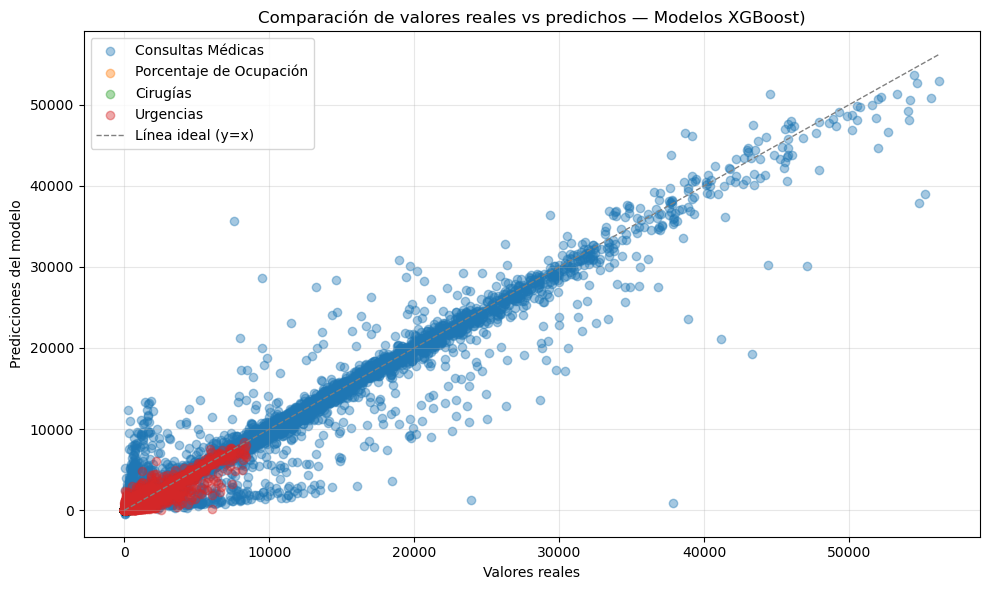

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Consultas Médicas 
plt.scatter(
    y_test_c,
    model_consultas.predict(X_test),
    alpha=0.4,
    label="Consultas Médicas",
    color="tab:blue"
)

# Porcentaje de Ocupación 
plt.scatter(
    y_test_o,
    model_ocupacion.predict(X_test),
    alpha=0.4,
    label="Porcentaje de Ocupación",
    color="tab:orange"
)

# Cirugías 
plt.scatter(
    np.expm1(y_test_s),  # se deslogariza para comparar valores reales
    np.expm1(model_cirugias.predict(X_test)),
    alpha=0.4,
    label="Cirugías",
    color="tab:green"
)

# Urgencias
plt.scatter(
    y_test_u,
    model_urgencias.predict(X_test),
    alpha=0.4,
    label="Urgencias",
    color="tab:red"
)

# Estilo general
plt.plot([0, max(y_test_c.max(), y_test_u.max())],
         [0, max(y_test_c.max(), y_test_u.max())],
         color="gray", linestyle="--", linewidth=1, label="Línea ideal (y=x)")

plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Comparación de valores reales vs predichos — Modelos XGBoost)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


*El gráfico muestra cómo se comparan los valores reales con las predicciones de los modelos de consultas médicas, ocupación, cirugías y urgencias.
Cuando los puntos están cerca de la línea diagonal, significa que las predicciones son acertadas.
En este caso, la mayoría de los puntos están alineados con esa línea, lo que indica que los modelos funcionan bien y logran estimar los valores reales con buena precisión.
Las pequeñas diferencias que se ven son normales y reflejan la variación natural entre hospitales o meses*

## Carga y revisión de hospitales en el dataset de la API

In [9]:
# Cargar el archivo que usa la API
mem = pd.read_csv("proyecciones_filtradas.csv")

# Ver cuántos hospitales únicos hay
print("Hospitales únicos:", mem["establecimiento_nombre"].nunique())

# Mostrar los primeros 20 nombres
print(mem["establecimiento_nombre"].dropna().unique()[:20])


Hospitales únicos: 341
['ASILO Y UNIDAD SANITARIA DR. ALBERT SCHWEITZER'
 'CENTRO DE ALTA COMPLEJIDAD CARDIOVASCULAR PTE. J.D. PERON'
 'CENTRO DE ATENCION PRIMARIA DE LA SALUD URI RAMON CARRILLO'
 'CENTRO DE DIA'
 'CENTRO DE DIAGNOSTICO Y TRATAMIENTO  N° 1 DR. JAVIER SABATO'
 'CENTRO DE MEDICINA PREVENTIVA ZONA NORTE'
 'CENTRO DE SALUD DR. ARANA RIO TALA' 'CENTRO DE SALUD DR. HORACIO CANESI'
 'CENTRO DE SALUD SAN MANUEL' 'CENTRO GERIATRICO DR. ERNESTO L. PINTO'
 'CENTRO GERIATRICO HOSTAL DE LOS ABUELOS'
 'CENTRO MUNICIPAL DE SALUD DEL PARTIDO DE TRES ARROYOS (EX HOGAR DR. IGNACIO PIROVANO)'
 'CENTRO PROVINCIAL DE ATENCION - GONZALEZ CATAN (LA MATANZA)'
 'CENTRO PROVINCIAL DE ATENCION - PIGUE (SAAVEDRA)' 'CIC SALTO'
 'CIC SAN PEDRO' 'CLINICA Y MATERNIDAD MUNICIPAL GONZALEZ CHAVES'
 'ENTE DESCENTRALIZADO HOSPITAL DR. ANGEL MARZETTI'
 'GERIATRICO MUNICIPAL ALBERTO MENDITEGUY'
 'HOGAR DE ANCIANOS ARNALDO INCHAUSPE']


# Conclusión General del Proyecto

El sistema desarrollado logra cumplir con el objetivo principal de predecir la demanda hospitalaria en distintos servicios clave — consultas médicas, porcentaje de ocupación, cirugías y urgencias — a partir de datos históricos y variables externas como el clima, los feriados y los efectos del COVID-19.

Los modelos entrenados con XGBoost demostraron un buen nivel de precisión y generalización, con métricas estables y sin señales de sobreajuste. Esto significa que las predicciones se mantienen consistentes tanto en los datos de entrenamiento como en los de prueba, lo cual refuerza su confiabilidad para el uso práctico.

El análisis anual y los gráficos de comparación entre valores reales y predichos muestran que las estimaciones siguen de cerca las tendencias observadas, capturando correctamente los patrones estacionales y las variaciones de demanda.

En conjunto, el modelo y la API creada permiten anticipar la presión sobre los recursos hospitalarios (camas, personal, quirófanos) y facilitar la planificación operativa y de insumos

| Variable | Error Medio (MAE) | R² | Evaluación |
|-----------|------------------|----|-------------|
| Consultas Médicas | 593.3 | 0.96 | Buen rendimiento |
| % de Ocupación | 0.29 | 0.90 | Resultados confiables |
| Cirugías (log) | 0.16 | 0.94 | Predicciones estables |
| Urgencias | 109.4 | 0.93 | Buen nivel de precisión |

En general, los resultados obtenidos permiten anticipar la demanda hospitalaria mensual con bastante exactitud, lo que puede ser de gran ayuda para planificar turnos, asignar personal y prever el uso de quirófanos y recursos médicos.  
Este tipo de predicciones mejora la capacidad de los hospitales para responder ante aumentos o disminuciones en la demanda y evitar tanto la saturación como el desperdicio de recursos.